### Dependencies

In [1]:

from stream_processing import *
from event_detection import *

from stream_processing import *
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import torch
import sys
from html_generation import compile_report_html
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import torch
import sys
from earthquake import Earthquake
from obspy import read
from IPython.display import Image, display
from email_sending import *
from station import Station
from catalog import Catalog
from report import Report, plot_catalogue

### Initiating Parameters For The Day

In [2]:
p_only=True
simplified = False

In [3]:
station = Station('AM', 'R50D6', 'https://data.raspberryshake.org', "2024-06-01")
print(station)

Station AM.R50D6 at https://data.raspberryshake.org
Location: 54.76576576576576, -1.561623996769607
Report Date: 2024-06-01
Data Folder: D:\Dissertation\data\AM.R50D6\2024-06-01
Report Folder: D:\Dissertation\data\AM.R50D6\2024-06-01\report



### Station Stream Download

Data for 2024-06-01 already exists.
1 Trace(s) in Stream:
AM.R50D6.00.EHZ | 2024-05-31T23:00:00.004000Z - 2024-06-02T01:00:00.004000Z | 100.0 Hz, 9360001 samples


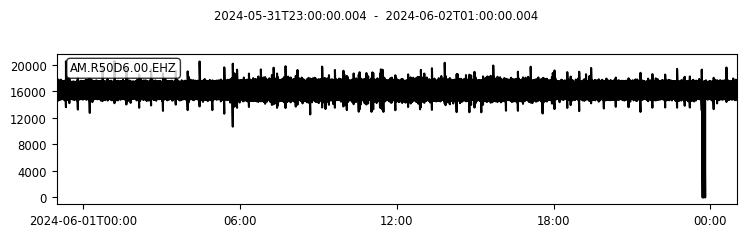

In [4]:
# Download stream and save to file
stream_file = station.download_stream_data(overwrite=False)

if stream_file:
    original_stream = read(stream_file)
    print(original_stream)
    original_stream.plot();
else:
    print("Error: No data file available to read.")

### Stream Signal Cleaning

Demean, Detrend, Outlier Removal And Bandpass Filtering

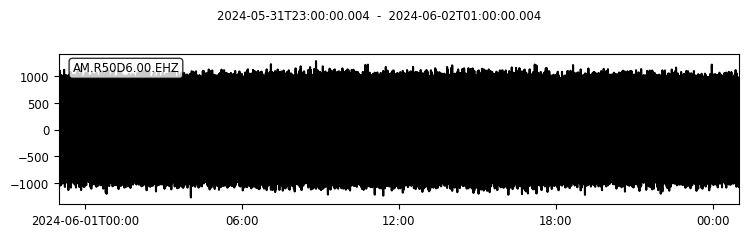

In [5]:
processed_stream = process_stream(original_stream)
processed_stream.plot();

Denoise Using Pretrained DeepDenoiser Model

CUDA available. Running on GPU
Stream saved to D:\Dissertation\data\AM.R50D6\2024-06-01\2024-06-01_AM.R50D6..Z.processed.mseed


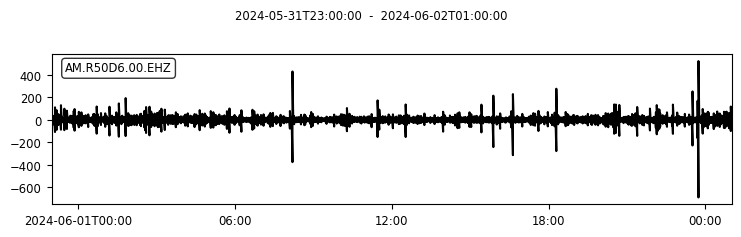

In [6]:
# Denoising the stream 
processed_stream = denoise_stream(processed_stream)

# Save processed stream to file
save_stream(station, processed_stream, "processed")

# Showing denoised stream
processed_stream.plot();

### Identify Events From Stream

Pre-trained Phase Picking Model

In [7]:
# Detect P and S waves from stream
predictions, annotated_stream = predict_and_annotate(processed_stream)

# Filter by confidence threshold
predictions = filter_confidence(predictions, p_threshold = 0.7 , s_threshold = 1)

# Save Picked Phases And Annotated Stream To Files
save_stream(station, annotated_stream, "processed.annotated")

# Show results
predictions

CUDA available. Running on GPU
Stream saved to D:\Dissertation\data\AM.R50D6\2024-06-01\2024-06-01_AM.R50D6..Z.processed.annotated.mseed


[{'peak_time': 2024-05-31T23:17:09.010000Z,
  'peak_confidence': 0.833264,
  'phase': 'P'},
 {'peak_time': 2024-05-31T23:38:35.020000Z,
  'peak_confidence': 0.79819787,
  'phase': 'P'},
 {'peak_time': 2024-06-01T00:10:06.010000Z,
  'peak_confidence': 0.71661174,
  'phase': 'P'},
 {'peak_time': 2024-06-01T01:52:38.000000Z,
  'peak_confidence': 0.75141174,
  'phase': 'P'},
 {'peak_time': 2024-06-01T02:35:05.020000Z,
  'peak_confidence': 0.8047632,
  'phase': 'P'},
 {'peak_time': 2024-06-01T02:45:35.020000Z,
  'peak_confidence': 0.771888,
  'phase': 'P'},
 {'peak_time': 2024-06-01T03:01:36.000000Z,
  'peak_confidence': 0.7136427,
  'phase': 'P'},
 {'peak_time': 2024-06-01T03:04:38.020000Z,
  'peak_confidence': 0.8134568,
  'phase': 'P'},
 {'peak_time': 2024-06-01T05:40:52.070000Z,
  'peak_confidence': 0.7570679,
  'phase': 'P'},
 {'peak_time': 2024-06-01T11:32:41.020000Z,
  'peak_confidence': 0.784483,
  'phase': 'P'},
 {'peak_time': 2024-06-01T12:17:36.010000Z,
  'peak_confidence': 0.777

### Request Catalog

In [8]:
# Initiate a new Catalog object
catalog = Catalog(station, radmin=0, radmax=90, minmag=4, maxmag=10)

# Specify multiple providers as fallback options
providers = [ "IRIS", "USGS", "EMSC"]

# Download catalog
catalog.request_catalogue(providers)

### Catalog Events Processing

In [9]:
if catalog.events:
    catalogued_earthquakes = catalog.process_catalogue()
    for eq in catalogued_earthquakes:
        print(eq)

Earthquake ID: 2024-06-01_01
Provider: IRIS
Provider Event ID: smi:service.iris.edu/fdsnws/event/1/query?eventid=11849484
Time: 2024-06-01T20:32:52.926000Z
Latitude: 9.6163, Longitude: -84.1099
Depth: 53.54 km
Magnitude: 4.1 mb
Epicentral Distance: 8658.198818809235 km
P Predicted: 2024-06-01T20:44:45.041786Z, S Predicted: 2024-06-01T20:54:34.543827Z
P Detected: None, S Detected: None
P Confidence: None, S Confidence: None
P Error: None, S Error: None
Catalogued: Yes, Detected: No
----------------------------------------
Earthquake ID: 2024-06-01_02
Provider: IRIS
Provider Event ID: smi:service.iris.edu/fdsnws/event/1/query?eventid=11850151
Time: 2024-06-01T19:17:55.277000Z
Latitude: 51.1627, Longitude: -178.8859
Depth: 41.325 km
Magnitude: 4.0 mb
Epicentral Distance: 8233.770731788318 km
P Predicted: 2024-06-01T19:29:28.194031Z, S Predicted: 2024-06-01T19:38:59.605197Z
P Detected: None, S Detected: None
P Confidence: None, S Confidence: None
P Error: None, S Error: None
Catalogued: Ye

### Matching And Merging Events From Catalog And Station Stream

In [10]:
# Using a time tolerance as thresholds for matching signals
earthquakes =  match_and_merge(catalogued_earthquakes, predictions, tolerance_p = 10, tolerance_s = 0, p_only = p_only)

# Add time error values for matched earthquakes
for eq in earthquakes:
    eq.update_errors()
    
# Save processed list of all events to file
save_list(earthquakes, station,"completed")

List saved to D:\Dissertation\data\AM.R50D6\2024-06-01\report\2024-06-01.completed.csv


### Results Statistics

In [11]:
stats = calculate_matching_stats(earthquakes)
print(f"Number of catalogued events: {stats[0]}")
print(f"Number of matched events: {stats[1]}")
print(f"Number of not detected events: {stats[2]}")
print(f"Number of events not in catalogue: {stats[3]}")
print(f"Number of P waves identified: {stats[4]}")
print(f"Number of S waves identified: {stats[5]}")


Number of catalogued events: 16
Number of matched events: 1
Number of not detected events: 15
Number of events not in catalogue: 17
Number of P waves identified: 1
Number of S waves identified: 0


### Report Assets Generation

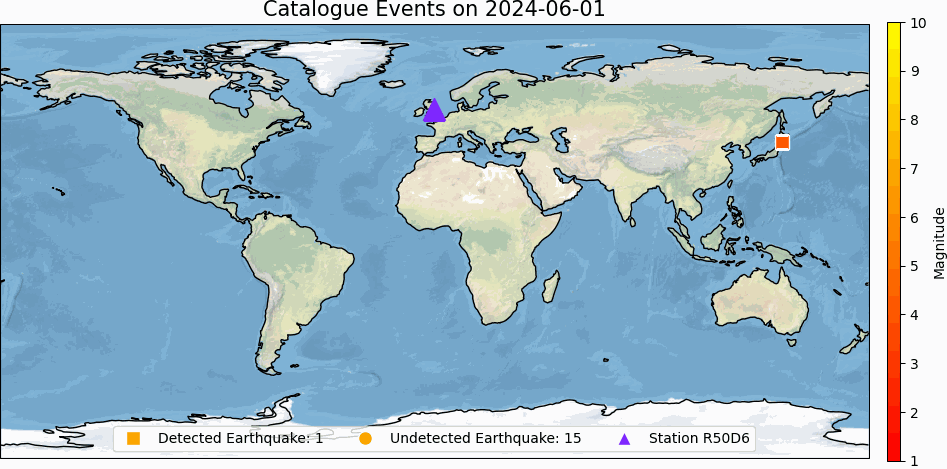

In [12]:

catalogue_plot = plot_catalogue(earthquakes,station, fill_map = True, create_gif=True)
display(Image(filename=catalogue_plot))

Wave+Annotation Plots For Matched Events To File Using Event ID

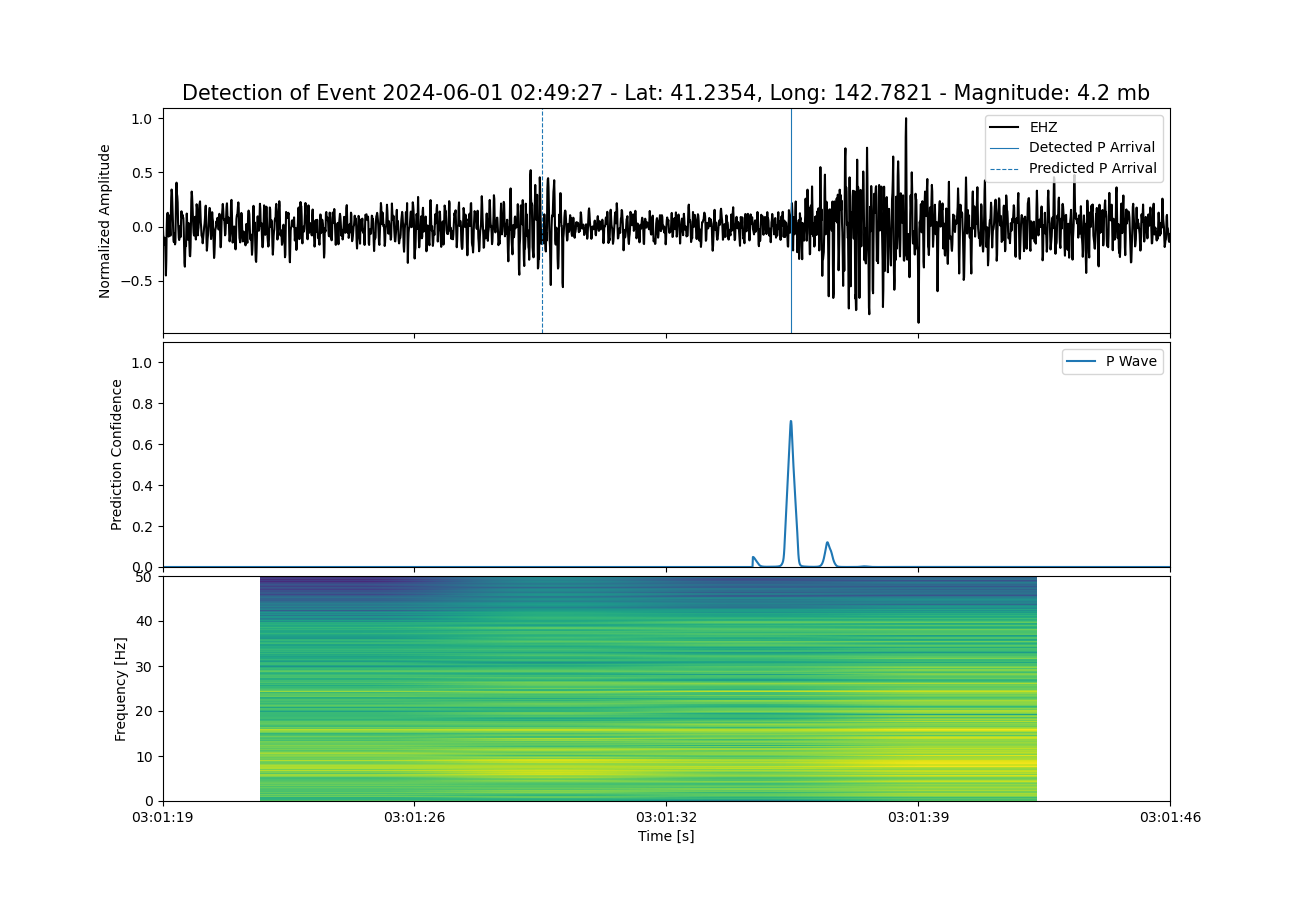

In [13]:
matched_events = [eq for eq in earthquakes if eq.catalogued and eq.detected]

for earthquake in matched_events:
    if matched_events:  
        # Generate the plot for each earthquake
        earthquake.generate_plot(processed_stream, annotated_stream, path=station.report_folder, simplified = simplified, p_only = p_only)
        
        display(Image(filename=earthquake.plot_path))


In [18]:
# Create a new Report object with necessary files and info
report = Report(station, earthquakes, processed_stream, annotated_stream, simplified=simplified, p_only=p_only,fill_map = True, create_gif=True)

# Generate image assets and html codes for the email
report.construct_email()

# Send the email
report.send_email('xmpg69@durham.ac.uk')

HTML report generated: D:\Dissertation\data\AM.R50D6\2024-06-01\report\2024-06-01_report.html
Email message compiled successfully.
Connecting to SMTP server...
Logged in to SMTP server.
Email sent successfully.
Disconnected from SMTP server.


In [23]:
report.generate_catalogue_plot()

'D:\\Dissertation\\data\\AM.R50D6\\2024-06-01\\report\\catalogued_plot_2024-06-01.gif'